In this project I reimplement the method proposed in paper [Mean-Variance Loss for Deep Age Estimation from a Face](https://openaccess.thecvf.com/content_cvpr_2018/papers/Pan_Mean-Variance_Loss_for_CVPR_2018_paper.pdf). The paper proposed a new loss function for age estimation problem based on mean and variance of age distribution. The result had shown that this loss function had increased the performance of age estimation system. This is a PyTorch implementation of this method, include a full pipeline of experiment, I try to create a project as much reproduciblity as posible. The dataset I used are FG-Net dataset which include 1002 face images from 0 to 69 year olds.




#### First you need to download the dataset from [All-Age-Faces-Dataset](https://github.com/JingchunCheng/All-Age-Faces-Dataset), upload the dataset somewhere on your Drive then connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#### Download timm package use for define model, and wandb package use for tracking and logging experiment data

In [ ]:
!pip install -qU wandb
!pip install -qU timm

     |████████████████████████████████| 1.6 MB 8.0 MB/s 
     |████████████████████████████████| 133 kB 74.9 MB/s 
     |████████████████████████████████| 97 kB 9.3 MB/s 
     |████████████████████████████████| 170 kB 69.7 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 376 kB 7.5 MB/s 


#### Next step is to install packages use for this project

In [ ]:
#Build-in python lib
import os
import time
import datetime
import pytz
import glob
import random
from typing import Dict, List

#Data processing and visualization
import cv2
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from sklearn.model_selection import KFold

#Model training and inference
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torch.cuda.amp as amp
import torchvision.transforms as torchtransform
import wandb

#### Define some variable to store path to data and perform some data analysis steps

In [ ]:
DATA_PATH = Path('/content/drive/My Drive/WORKSPACE/HK192/AI/AI_COLAB/All_Age_Face/aglined faces')

In [ ]:
files = os.listdir(DATA_PATH)

print(len(files))

13322


In [ ]:
print([name for name in files[:10]])

['12319A54.jpg', '12313A54.jpg', '12366A55.jpg', '12330A54.jpg', '12394A55.jpg', '12336A54.jpg', '12377A55.jpg', '12396A55.jpg', '12358A55.jpg', '12364A55.jpg']


In [ ]:
def get_no(path):
  name = path.split(os.sep)[-1]
  no_str = name.split('A')[0]
  no = int(no_str)
  return no

def get_age(path):
  name = path.split(os.sep)[-1]
  a_idx = name.find('A')
  age_str = name[a_idx+1:a_idx+3]
  age = int(age_str)
  return age 

def age2idx(df: pd.DataFrame):
  unique_age = sorted(pd.unique(df['age']).tolist())
  age_to_idx = {k: v for k, v in zip(unique_age, range(0, len(unique_age)))}
  return age_to_idx

In [ ]:
df = pd.DataFrame()

df['image_path'] = sorted(glob.glob(str(DATA_PATH) + '/*.*'))
df['no. person'] = df['image_path'].apply(get_no)
df['age'] = df['image_path'].apply(get_age)

In [ ]:
df.head()

,image_path,no. person,age
0,/content/drive/My Drive/WORKSPACE/HK192/AI/AI_...,0,2
1,/content/drive/My Drive/WORKSPACE/HK192/AI/AI_...,1,2
2,/content/drive/My Drive/WORKSPACE/HK192/AI/AI_...,2,2
3,/content/drive/My Drive/WORKSPACE/HK192/AI/AI_...,3,2
4,/content/drive/My Drive/WORKSPACE/HK192/AI/AI_...,4,2


In [ ]:
df.describe()

,no. person,age
count,13322.000000,13322.000000
mean,6660.500000,34.611545
std,3845.874478,17.069689
min,0.000000,2.000000
25%,3330.250000,24.000000
50%,6660.500000,33.000000
75%,9990.750000,44.000000
max,13321.000000,80.000000


In [ ]:
print('Number of unique age in dataset: {}'.format(len(pd.unique(df['age']))))

Number of unique age in dataset: 79


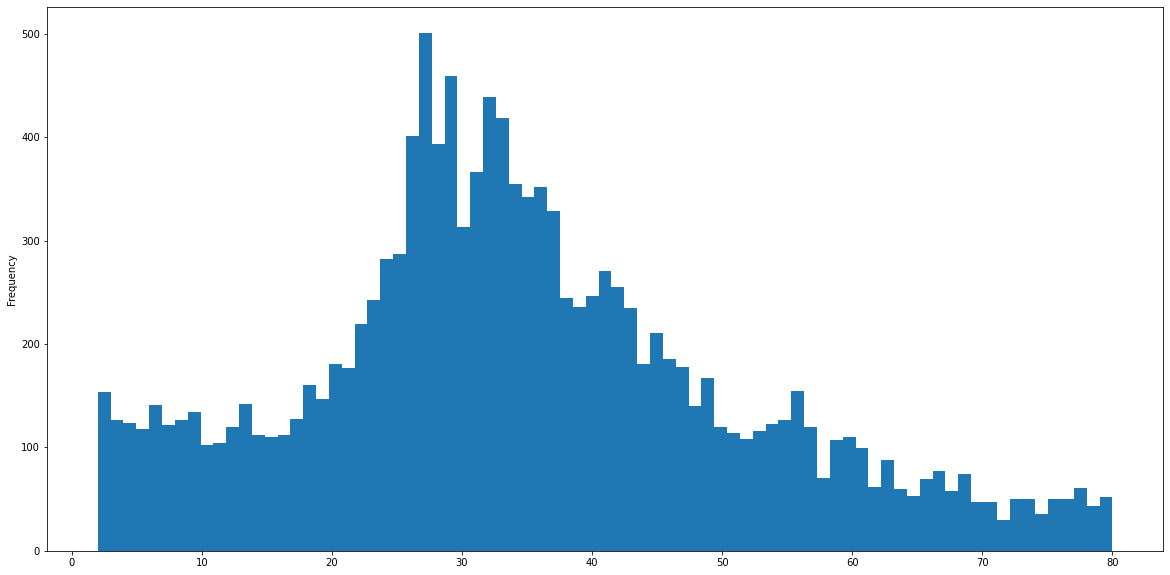

In [ ]:
plt.figure(figsize=(20, 10))
ax = df['age'].plot.hist(bins=79)

In [ ]:
map_dict = age2idx(df)
df['idx'] = df['age'].apply(lambda s: map_dict[s])
df.head()

,image_path,no. person,age,idx
0,/content/drive/My Drive/WORKSPACE/HK192/AI/AI_...,0,2,0
1,/content/drive/My Drive/WORKSPACE/HK192/AI/AI_...,1,2,0
2,/content/drive/My Drive/WORKSPACE/HK192/AI/AI_...,2,2,0
3,/content/drive/My Drive/WORKSPACE/HK192/AI/AI_...,3,2,0
4,/content/drive/My Drive/WORKSPACE/HK192/AI/AI_...,4,2,0


In [ ]:
def build_folds(df, n_folds, seed):
  skf = KFold(n_splits=n_folds, random_state=seed, shuffle=True)
  fold_df = df.copy()

  for idx, (_, val_idx) in enumerate(skf.split(X=fold_df['image_path'])):
    fold_df.loc[val_idx, 'fold'] = idx+1
  
  fold_df['fold'] = fold_df['fold'].astype('uint8')
  return fold_df

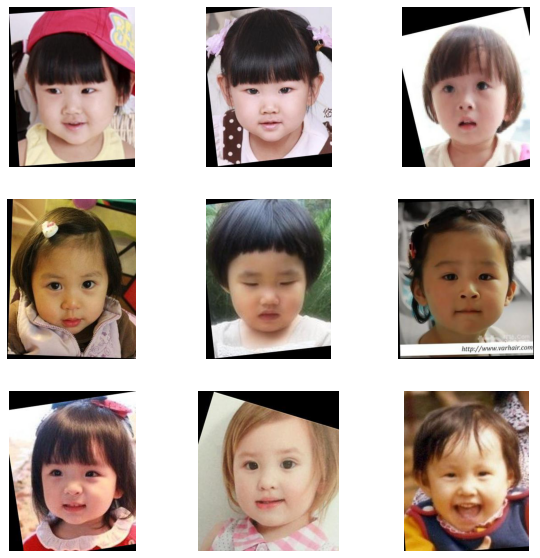

In [ ]:
plt.figure(figsize=(10, 10))
for idx in range(9):
  plt.subplot(3, 3, idx+1)
  img = Image.open(df.loc[idx, 'image_path']).convert('RGB')
  plt.imshow(img)
  plt.axis('off')
plt.show()

#### Define a CONFIG class contain all hyper-parameters for training and configuration for the experiments, include n_epochs, model, lr, optimizer, scheduler, batch size, and data augmentation. Sanity check is used for the case when you want to check if the pipeline is running correctly by just training on 1 batch of data.

In [ ]:
class CONFIG:
  exp_name = 'Experiment 1'
  seed=1999
  sanity_check = False
  n_folds=3
  if sanity_check:
    n_epochs=3
  else:
    n_epochs=60
  early_stop=True
  model="resnet50"
  target_list = sorted(pd.unique(df['age']).tolist())
  optimizer={
      "name": "AdamW",
      "params": {
          "lr":1e-3,
          "weight_decay": 1e-4
      }
  }
  lambda1=0.2
  lambda2=0.05
  batch_size=64
  scheduler={
      "name": "CosineAnnealingLR",
      "params": {
          "T_max": n_epochs,
          "eta_min": 1.0e-6,
          "last_epoch": -1,
          "verbose": False,
      }
  }
  augmentation={
      "Resize": {"size": (256, 256)},
      "ColorJitter": {
          "brightness": .5,
          "hue": .3
      },  
      "RandomAutocontrast": {"p": 0.5},
      "RandomAdjustSharpness": {"sharpness_factor": 2},
      "RandomHorizontalFlip": {"p": 0.5}
  }
  val_augmentation={
      "Resize": {"size": (256, 256)}
  }

  if sanity_check:
    checkpoint_dir = DATA_PATH.resolve().parent / "test_ckp"
  else:
    checkpoint_dir= DATA_PATH.resolve().parent / "checkpoints" / exp_name

In [ ]:
def seed_everything(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.cuda.manual_seed(seed)  # pytorch (both CPU and CUDA)
  np.random.seed(seed)  # for numpy pseudo-random generator
  random.seed(seed)  # set fixed value for python built-in pseudo-random generator
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

#### Define some utilization function

In [ ]:
#Utils functions
def denormalize(mean, std, image: torch.FloatTensor):
  assert len(image.shape) != 3 or len(image.shape) != 4, "Unexpected shape of image" 
  std = torch.tensor(std, device=image.device).view(3,1,1)
  mean = torch.tensor(mean, device=image.device).view(3,1,1)
  image = image*std + mean
  image = image*255.0
  if len(image.shape) == 4:
    image = image.permute(0, 2, 3, 1).int()
  else:
    image = image.permute(1, 2, 0).int()
  return image

def detach_gpu(tsor):
  return tsor.detach().cpu().numpy()

#### Define a Transform class use for data augmentation

In [ ]:
class Transform:
  def __init__(self, aug_dict=None):
    self.mean = [0.485, 0.456, 0.406]
    self.std = [0.229, 0.224, 0.225]
    trans_method = [getattr(torchtransform, name)(**kwargs) for name, kwargs in aug_dict.items()] if aug_dict else []
    extend_method = [
                     torchtransform.ToTensor(), 
                     torchtransform.Normalize(self.mean, self.std)
                    ]
    trans_method += extend_method
    self.transform = torchtransform.Compose(trans_method)
  
  def __call__(self, image: Image) -> torch.FloatTensor:
    image = self.transform(image)
    return image

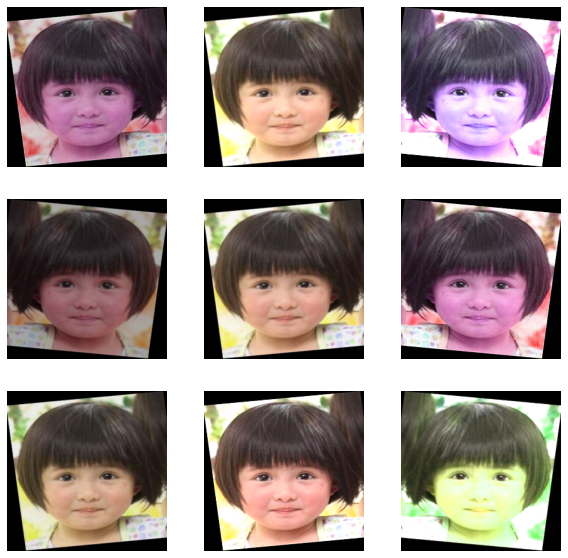

In [ ]:
exam_transform = CONFIG.augmentation
transform = Transform(exam_transform)

plt.figure(figsize=(10, 10))
for idx in range(9):
  plt.subplot(3, 3, idx+1)
  img = Image.open(df.loc[10, 'image_path']).convert('RGB')
  trans_img = transform(img)
  trans_img = denormalize(transform.mean, transform.std, trans_img)
  trans_img = trans_img.numpy()
  plt.imshow(trans_img)
  plt.axis('off')
plt.show()

#### AgeDataset will return a sample include an image, a groundtruth age, and an image's name

In [ ]:
class AgeDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    path = self.df.loc[idx, 'image_path']
    img_name = path.split(os.sep)[-1]
    image = Image.open(path).convert('RGB')
    target = self.df.loc[idx, 'age']
    target = torch.FloatTensor([target])
    age_idx = self.df.loc[idx, 'idx']
    age_idx = torch.LongTensor([age_idx])

    if self.transform:
      image = self.transform(image)

    return image, target, age_idx, img_name

#### AgeModel is created by using timm's pretrained model

In [ ]:
class AgeModel(nn.Module):
  def __init__(self, backbone="resnet50", pretrained=True, n_classes=1000):
    super(AgeModel, self).__init__()
    self.backbone = timm.create_model(backbone, pretrained=pretrained)
    self.backbone.reset_classifier(num_classes=0, global_pool='avg')
    in_features = self.backbone.num_features
    self.head = nn.Linear(in_features=in_features, out_features=n_classes, bias=True)
  
  def forward(self, x):
    x = self.backbone(x)
    x = self.head(x)
    return x

  def get_parameters(self, weight_decay, no_decay=['bias', 'BatchNorm2d.weight']):
    model_params = [{
                "params": [p for n, p in self.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": weight_decay,
            },
            {
                "params": [p for n, p in self.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
    ]
    return model_params

#### This is the reimplementation part of the paper. The paper proposed 2 new loss include MeanLOss and VarianceLOss. The final loss is a combination of Softmax loss and these 2 new loss function

In [ ]:
class MeanLoss(nn.Module):
  def __init__(self, device, target_list: List = []):
    """
    Args:
      - device: torch.device
      - target_list: list of all posible age start 
      from smallest age to larest age in the dataset
    """
    super().__init__()
    self.target_list=torch.tensor(target_list, device=device)

  def _mean(self, preds: torch.FloatTensor):
    probs = F.softmax(preds, dim=1)
    mean = (self.target_list*probs).sum(dim=1)
    return mean

  def forward(self, preds: torch.FloatTensor, targets: torch.LongTensor):
    targets = targets.float()
    b_mean = self._mean(preds)
    loss = F.mse_loss(b_mean, targets)
    return loss

class VarianceLoss(nn.Module):
  def __init__(self, device, target_list: List = []):
    """
    Args:
      - device: torch.device
      - target_list: list of all posible age start from smallest age 
      to larest age in the dataset
    """
    super().__init__()
    self.target_list = torch.tensor(target_list, device=device)

  def _variance(self, preds: torch.FloatTensor):
    probs = F.softmax(preds, dim=1)
    mean = (self.target_list*probs).sum(dim=1).unsqueeze(-1)
    variance = probs*(self.target_list-mean)**2
    variance = variance.sum(dim=1)
    return variance

  def forward(self, preds: torch.FloatTensor):
    return self._variance(preds).mean()

class ComboLoss(nn.Module):
  def __init__(self, lambda1, lambda2, device, target_list: List = []):
    """
      Args:
      - lambda1: hyperparameters for weight the mean loss
      - lambda2: hyperparameters for weight the variance loss
      - device: torch.device
      - target_list: list of all posible age start from smallest age 
      to larest age in the dataset
    """
    super().__init__()
    self.l1 = lambda1
    self.l2 = lambda2
    self.mean_loss = MeanLoss(device, target_list)
    self.var_loss = VarianceLoss(device, target_list)
    self.celoss = nn.CrossEntropyLoss()
  
  def forward(self, preds, targets, age_idxs):
    m_loss = self.mean_loss(preds, targets)
    v_loss = self.var_loss(preds)
    ce_loss = self.celoss(preds, age_idxs)
    loss = ce_loss + self.l1*m_loss\
          + self.l2*v_loss
    return loss, m_loss, v_loss, ce_loss

In [ ]:
class AverageMeter:
  def __init__(self):
    self.value = 0
    self.step = 0
  
  def update(self, loss):
    self.value += loss
    self.step += 1
  
  def avg(self):
    return self.value / float(self.step)

class MeanAbsoluteError:
  def __init__(self):
    self.sum_abs_error = 0
    self.total = 0
  
  def update(self, preds: torch.Tensor, targets: torch.Tensor):
    sum_abs_error = torch.sum(torch.abs(preds - targets))
    n_eles = targets.numel()
    self.sum_abs_error += sum_abs_error.item()
    self.total += n_eles

  def compute(self):
    return self.sum_abs_error / self.total

#### Class Trainer include the whole training and evaluation pipeline

In [ ]:
class Trainer:
  def __init__(self, config, train_loader, valid_loader, device, fold):
    """
    Args:
     - config: class CONFIG object
     - train_loader: dataloader for train part
     - valid_loader: dataloader for valid part
     - fold: current fold 
     - device: torch.device
    """
    self.config = config
    self.fold = fold
    self.model = AgeModel(
        backbone=config.model, 
        pretrained=True, 
        n_classes=len(config.target_list)
    ).to(device)

    self.optimizer = getattr(optim, config.optimizer['name'])(
        self.model.get_parameters(config.optimizer['params']['weight_decay']), 
        **config.optimizer['params']
    )

    self.criterion = ComboLoss(config.lambda1, config.lambda2, device, config.target_list)
    self.scheduler = getattr(lr_scheduler, config.scheduler['name'])(self.optimizer, **config.scheduler['params'])

    self.scaler = amp.GradScaler()

    self.train_loader = train_loader
    self.valid_loader = valid_loader

    self.device = device
    self.patience = 10
    wandb.watch(self.model, self.criterion, log='all', log_freq=1)
  
  def train_and_evaluate(self, resume=False):
    if resume:
      best_mae, start_epoch = self.load_checkpoint()
      print('Resume training fold {} from epoch {}'.format(self.fold, start_epoch))
    else:
      best_mae = np.inf
      start_epoch = 0

    for epoch in range(start_epoch, self.config.n_epochs):
      cur_lr = self.optimizer.param_groups[0]["lr"]
      timestamp = datetime.datetime.now(pytz.timezone("Asia/Singapore")).strftime(
                  "%Y-%m-%d %H-%M-%S"
      )
      print('\n{}\nLR: {}'.format(timestamp, cur_lr))
      wandb.log({'LR': cur_lr})

      start_time = time.time()

      train_loss, train_mae = self.train_one_epoch(epoch)
      val_loss, val_mae = self.evaluation()

      elapsed_time = time.strftime(
                "%H:%M:%S", time.gmtime(time.time() - start_time)
      )

      print("Epoch: {}, Train loss: {}, Train MAE: {}, Valid loss: {}, Valid MAE: {}, "
      "Elapsed Time: {}".format(
          epoch+1, 
          train_loss, 
          train_mae, 
          val_loss, 
          val_mae, 
          elapsed_time))

      self.scheduler.step()

      is_best_mae = (val_mae < best_mae)
      if val_mae < best_mae:
        best_mae = val_mae
        wandb.run.summary["best_mae"] = best_mae
        self.patience = 10
    
      state_dict = {
          'model': self.model.state_dict(),
          'optim': self.optimizer.state_dict(),
          'scheduler': self.scheduler.state_dict(),
          'epoch': epoch+1,
          'best_mae': best_mae,
      }
      self.save_checkpoint(state_dict, is_best_mae)
      
      if not is_best_mae:
        if self.config.early_stop:
          if self.patience <= 0:
            print('Early Stopping')
            break
          else:
            self.patience -= 1

  def train_one_epoch(self, cur_epoch):
    avg_loss = AverageMeter()
    avg_m_loss = AverageMeter()
    avg_v_loss = AverageMeter()
    avg_ce_loss = AverageMeter()
    mae = MeanAbsoluteError()

    self.model.train()
    with tqdm(total=len(self.train_loader), desc = 'Epoch {}:'.format(str(cur_epoch+1))) as t:
      for idx, batch_data in enumerate(self.train_loader):
        image = batch_data[0].to(self.device)
        target = batch_data[1].to(self.device).squeeze(1)
        age_idx = batch_data[2].to(self.device).squeeze(1)

        with amp.autocast():
          output = self.model(image)
          probs = F.softmax(output, dim=1)
          estimate_age = torch.round((torch.tensor(self.config.target_list, device=self.device)*probs).sum(dim=1))
          loss, m_loss, v_loss, ce_loss = self.criterion(output, target, age_idx)
        
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        
        avg_loss.update(loss.item())
        avg_m_loss.update(m_loss.item())
        avg_v_loss.update(v_loss.item())
        avg_ce_loss.update(ce_loss.item())
        mae.update(estimate_age, target)

        wandb.log({
            "train loss": avg_loss.avg(),
            "train mean loss": avg_m_loss.avg(),
            "train var loss": avg_v_loss.avg(),
            "train ce loss": avg_ce_loss.avg(),
            "train mae": mae.compute()
        })

        t.set_postfix(loss='{:05.3f}'.format(avg_loss.avg()), mae='{:05.3f}'.format(mae.compute()))
        t.update()

    return avg_loss.avg(), mae.compute()

  def evaluation(self):
    avg_loss = AverageMeter()
    avg_m_loss = AverageMeter()
    avg_v_loss = AverageMeter()
    avg_ce_loss = AverageMeter()
    mae = MeanAbsoluteError()

    log_images = {}
    self.model.eval()
    with torch.no_grad():
      for idx, batch_data in enumerate(self.valid_loader):
        image = batch_data[0].to(self.device)
        target = batch_data[1].to(self.device).squeeze(1)
        age_idx = batch_data[2].to(self.device).squeeze(1)
        img_names = batch_data[3]

        outputs = self.model(image)
        probs = F.softmax(outputs, dim=1)
        estimate_age = torch.round((torch.tensor(self.config.target_list, device=self.device)*probs).sum(dim=1))
        loss, m_loss, v_loss, ce_loss = self.criterion(outputs, target, age_idx)

        mae.update(estimate_age, target)
        avg_loss.update(loss.item())
        avg_m_loss.update(m_loss.item())
        avg_v_loss.update(v_loss.item())
        avg_ce_loss.update(ce_loss.item())

        wandb.log({
            "valid loss": avg_loss.avg(),
            "valid mean loss": avg_m_loss.avg(),
            "valid var loss": avg_v_loss.avg(),
            "valid ce loss": avg_ce_loss.avg(),
            "valid mae": mae.compute()
        })

        if idx == len(self.valid_loader) - 1:
          num_sample = min(6, image.shape[0])
          n_img = denormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225], image[:num_sample])
          n_img = detach_gpu(n_img)
          log_images['images'] = n_img
          log_images['label'] = detach_gpu(target[:num_sample])
          log_images['preds'] = detach_gpu(estimate_age[:num_sample])
          log_images['name'] = img_names[:num_sample]
    
    log_table = wandb.Table(columns=["Name", "Face", "Age", "Pred Age"])
    for i in range(len(log_images['images'])):
      data = [log_images['name'][i], wandb.Image(log_images['images'][i]), log_images['label'][i], log_images['preds'][i]]
      log_table.add_data(*data)
    wandb.log({"Face age samples on validation set": log_table})

    return avg_loss.avg(), mae.compute()

  def save_checkpoint(self, state_dict, is_best_mae):
    if not os.path.exists(str(self.config.checkpoint_dir.parent)):
      os.mkdir(str(self.config.checkpoint_dir.parent))
      if not os.path.exists(str(self.config.checkpoint_dir)):
        print('Checkpoint dir does not exist, create one')
        os.mkdir(str(self.config.checkpoint_dir))
    
    #Save latest checkpoint
    print('Save last checkpoint')
    torch.save(state_dict, os.path.join(str(self.config.checkpoint_dir), '{}_last.pth'.format(self.fold)))

    if is_best_mae:
      print('Save best MAE checkpoint')
      #Save best mae checkpoint if exist
      torch.save(state_dict, os.path.join(str(self.config.checkpoint_dir), '{}_best_mae.pth'.format(self.fold)))

  def load_checkpoint(self):
    state_dict = torch.load(os.path.join(str(self.config.checkpoint_dir), '{}_last.pth'.format(self.fold)), map_location='cpu')
    self.model.load_state_dict(state_dict['model'])
    self.optimizer.load_state_dict(state_dict['optim'])
    self.scheduler.load_state_dict(state_dict['scheduler'])
    start_epoch = state_dict['epoch']
    best_mae = state_dict['best_mae']
    return best_mae, start_epoch

In [ ]:
def run(fold_df, fold, config, device, resume=False):
  if config.sanity_check:
    run = wandb.init(project="Age-Estimation-with-PyTorch-on-All-Age-Face", name='test_run')
  else:
    run = wandb.init(
        project="Age-Estimation-with-PyTorch-on-All-Age-Face", 
        name='run_fold_{}'.format(str(fold)), 
        resume=resume, 
        group=config.exp_name, 
        job_type='fold_{}'.format(str(fold))
    )

  hyperparams = {
      "model": config.model, 
      "epochs": config.n_epochs, 
      "init_lr":config.optimizer["params"]["lr"], 
      "bs": config.batch_size, 
      "ld1": config.lambda1, 
      "ld2": config.lambda2
  }

  wandb.config.update(hyperparams)

  #Create dataset
  print('-----------------------------------------')
  print('Creating dataset')
  train_df = fold_df[fold_df['fold'] != fold].reset_index(drop=True)
  val_df = fold_df[fold_df['fold'] == fold].reset_index(drop=True)

  if config.sanity_check:
    train_df = train_df[:config.batch_size*2]
    val_df = val_df[:config.batch_size*2]

  train_transform = Transform(config.augmentation)
  train_ds = AgeDataset(train_df, train_transform)
  print('Use {} samples for train dataset'.format(len(train_ds)))
  val_transform = Transform(config.val_augmentation)
  valid_ds = AgeDataset(val_df, val_transform)
  print('Use {} samples for val dataset'.format(len(valid_ds)))

  #Create loader
  train_dl = DataLoader(train_ds, batch_size=config.batch_size, num_workers=2, shuffle=True, pin_memory=True)
  val_dl = DataLoader(valid_ds, batch_size=config.batch_size, num_workers=2, shuffle=False, pin_memory=True)

  #Start training
  print('-----------------------------------------')
  print('Start training')
  trainer = Trainer(config, train_dl, val_dl, device, fold)
  trainer.train_and_evaluate(resume=resume)
  print('Finish training')
  print('-----------------------------------------')
  run.finish()

In [ ]:
!nvidia-smi

Wed Aug 25 10:58:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Main 
if __name__ == '__main__':
  seed = CONFIG.seed
  seed_everything(seed)
  device = ("cuda:0" if torch.cuda.is_available() else "cpu")
  fold_df = build_folds(df, CONFIG.n_folds, seed)
  if not CONFIG.sanity_check:
    for fold in range(1, CONFIG.n_folds + 1):
      print('Fold {}'.format(fold))
      run(fold_df, fold, CONFIG, device)
  else:
    print('Perform sanity check on fold 1')
    run(fold_df, 1, CONFIG, device)

wandb: Currently logged in as: dyle_cse (use `wandb login --relogin` to force relogin)


Fold 1


-----------------------------------------
Creating dataset
Use 8881 samples for train dataset
Use 4441 samples for val dataset
-----------------------------------------
Start training

2021-08-25 20-52-58
LR: 0.001


Epoch 1::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 1, Train loss: 48.684444070719984, Train MAE: 11.241752054948767, Valid loss: 41.97581909724644, Valid MAE: 10.133528484575546, Elapsed Time: 00:06:15
Checkpoint dir does not exist, create one
Save last checkpoint
Save best MAE checkpoint

2021-08-25 20-59-15
LR: 0.0009993154526099096


Epoch 2::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 2, Train loss: 34.68893759199184, Train MAE: 9.272154036707578, Valid loss: 31.966828400748117, Valid MAE: 8.78270659761315, Elapsed Time: 00:06:15
Save last checkpoint
Save best MAE checkpoint

2021-08-25 21-05-34
LR: 0.0009972636867364524


Epoch 3::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 3, Train loss: 28.842866732919816, Train MAE: 8.339601396239162, Valid loss: 35.109922122955325, Valid MAE: 9.348344967349696, Elapsed Time: 00:06:15
Save last checkpoint

2021-08-25 21-11-50
LR: 0.0009938503261272711


Epoch 4::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 4, Train loss: 23.86899764932317, Train MAE: 7.440603535637878, Valid loss: 24.409510830470495, Valid MAE: 7.533888763791939, Elapsed Time: 00:06:15
Save last checkpoint
Save best MAE checkpoint

2021-08-25 21-18-08
LR: 0.0009890847265665358


Epoch 5::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 5, Train loss: 21.961672432988667, Train MAE: 7.044702173178696, Valid loss: 22.398017488207135, Valid MAE: 7.229903174960595, Elapsed Time: 00:06:15
Save last checkpoint
Save best MAE checkpoint

2021-08-25 21-24-26
LR: 0.0009829799502313894


Epoch 6::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 6, Train loss: 20.318867230586868, Train MAE: 6.688323387005968, Valid loss: 21.867060817990986, Valid MAE: 7.060797117766269, Elapsed Time: 00:06:16
Save last checkpoint
Save best MAE checkpoint

2021-08-25 21-30-45
LR: 0.0009755527298894291


Epoch 7::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 7, Train loss: 19.20017099037445, Train MAE: 6.545096272942236, Valid loss: 22.444440562384468, Valid MAE: 7.018914658860617, Elapsed Time: 00:06:17
Save last checkpoint
Save best MAE checkpoint

2021-08-25 21-37-05
LR: 0.0009668234230353521


Epoch 8::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 8, Train loss: 17.037622122455844, Train MAE: 6.029050782569531, Valid loss: 21.153160067967008, Valid MAE: 6.694213015086692, Elapsed Time: 00:06:17
Save last checkpoint
Save best MAE checkpoint

2021-08-25 21-43-24
LR: 0.0009568159560924789


Epoch 9::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 9, Train loss: 16.65450852208858, Train MAE: 5.959689224186466, Valid loss: 19.18671066420419, Valid MAE: 6.487052465660887, Elapsed Time: 00:06:18
Save last checkpoint
Save best MAE checkpoint

2021-08-25 21-49-45
LR: 0.0009455577588320895


Epoch 10::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 10, Train loss: 15.465399783292263, Train MAE: 5.6589348046391175, Valid loss: 19.522522497177125, Valid MAE: 6.408466561585229, Elapsed Time: 00:06:16
Save last checkpoint
Save best MAE checkpoint

2021-08-25 21-56-04
LR: 0.000933079689190327


Epoch 11::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 11, Train loss: 15.587706620744664, Train MAE: 5.6959801824118905, Valid loss: 28.482941593442643, Valid MAE: 7.958793064625085, Elapsed Time: 00:06:16
Save last checkpoint

2021-08-25 22-02-22
LR: 0.000919415948688739


Epoch 12::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 12, Train loss: 15.671984363802903, Train MAE: 5.711744172953496, Valid loss: 27.955194786616733, Valid MAE: 7.922539968475569, Elapsed Time: 00:06:17
Save last checkpoint

2021-08-25 22-08-41
LR: 0.000904603988690286


Epoch 13::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 13, Train loss: 13.495160150871003, Train MAE: 5.199977480013512, Valid loss: 18.47285838127136, Valid MAE: 6.275613600540419, Elapsed Time: 00:06:16
Save last checkpoint
Save best MAE checkpoint

2021-08-25 22-15-00
LR: 0.0008886844077477568


Epoch 14::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 14, Train loss: 13.254569177147296, Train MAE: 5.1476185114288935, Valid loss: 18.331739248548235, Valid MAE: 6.1522179689259175, Elapsed Time: 00:06:18
Save last checkpoint
Save best MAE checkpoint

2021-08-25 22-21-21
LR: 0.0008717008403259582


Epoch 15::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 15, Train loss: 13.014151971117197, Train MAE: 5.108658934804639, Valid loss: 18.11669830594744, Valid MAE: 6.116190047286647, Elapsed Time: 00:06:18
Save last checkpoint
Save best MAE checkpoint

2021-08-25 22-27-42
LR: 0.0008536998372026803


Epoch 16::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 16, Train loss: 11.448793654819186, Train MAE: 4.681004391397365, Valid loss: 17.622512030601502, Valid MAE: 6.020941229452826, Elapsed Time: 00:06:19
Save last checkpoint
Save best MAE checkpoint

2021-08-25 22-34-04
LR: 0.0008347307378762495


Epoch 17::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 17, Train loss: 10.810755314586832, Train MAE: 4.50005629996622, Valid loss: 20.751833289010182, Valid MAE: 6.589732042332808, Elapsed Time: 00:06:19
Save last checkpoint

2021-08-25 22-40-25
LR: 0.0008148455353293937


Epoch 18::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 18, Train loss: 10.710400701426774, Train MAE: 4.450962729422362, Valid loss: 16.31043165751866, Valid MAE: 5.74420175636118, Elapsed Time: 00:06:19
Save last checkpoint
Save best MAE checkpoint

2021-08-25 22-46-47
LR: 0.0007940987335200902


Epoch 19::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 19, Train loss: 9.388528861587854, Train MAE: 4.060466163720302, Valid loss: 16.98331273623875, Valid MAE: 5.861067327178564, Elapsed Time: 00:06:18
Save last checkpoint

2021-08-25 22-53-07
LR: 0.0007725471979900058


Epoch 20::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 20, Train loss: 9.044803794339407, Train MAE: 3.9844612093232743, Valid loss: 18.019530391693117, Valid MAE: 6.108534113938302, Elapsed Time: 00:06:18
Save last checkpoint

2021-08-25 22-59-27
LR: 0.0007502499999999998


Epoch 21::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 21, Train loss: 8.386510581421337, Train MAE: 3.761851142889314, Valid loss: 17.314393132073537, Valid MAE: 5.929295203782932, Elapsed Time: 00:06:19
Save last checkpoint

2021-08-25 23-05-48
LR: 0.0007272682546199034


Epoch 22::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 22, Train loss: 8.479429636070197, Train MAE: 3.772773336335998, Valid loss: 18.888055324554443, Valid MAE: 6.316820535915334, Elapsed Time: 00:06:19
Save last checkpoint

2021-08-25 23-12-08
LR: 0.0007036649532163621


Epoch 23::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 23, Train loss: 11.552199518080238, Train MAE: 4.577637653417408, Valid loss: 18.54637496130807, Valid MAE: 6.155370412069353, Elapsed Time: 00:06:18
Save last checkpoint

2021-08-25 23-18-28
LR: 0.0006795047907978774


Epoch 24::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 24, Train loss: 9.87623204087182, Train MAE: 4.229140862515482, Valid loss: 18.91396474838257, Valid MAE: 6.392704345868048, Elapsed Time: 00:06:19
Save last checkpoint

2021-08-25 23-24-49
LR: 0.000654853988690286


Epoch 25::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 25, Train loss: 8.010074306735032, Train MAE: 3.6460984123409528, Valid loss: 15.84348361151559, Valid MAE: 5.6575095699166855, Elapsed Time: 00:06:20
Save last checkpoint
Save best MAE checkpoint

2021-08-25 23-31-12
LR: 0.0006297801130287089


Epoch 26::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 26, Train loss: 7.136712551116943, Train MAE: 3.3176444094133544, Valid loss: 17.019436945234027, Valid MAE: 5.872551227201081, Elapsed Time: 00:06:19
Save last checkpoint

2021-08-25 23-37-33
LR: 0.0006043518895634706


Epoch 27::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 27, Train loss: 6.871513198605545, Train MAE: 3.2200202679878394, Valid loss: 15.491294540677751, Valid MAE: 5.535690159873902, Elapsed Time: 00:06:18
Save last checkpoint
Save best MAE checkpoint

2021-08-25 23-43-55
LR: 0.0005786390152875952


Epoch 28::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 28, Train loss: 6.728811075361513, Train MAE: 3.13883571669857, Valid loss: 21.25550125667027, Valid MAE: 6.791713578022968, Elapsed Time: 00:06:19
Save last checkpoint

2021-08-25 23-50-16
LR: 0.0005527119674021929


Epoch 29::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 29, Train loss: 7.3280021784116895, Train MAE: 3.3683143790113728, Valid loss: 17.26668503625052, Valid MAE: 5.911281242963296, Elapsed Time: 00:06:20
Save last checkpoint

2021-08-25 23-56-37
LR: 0.0005266418101433503


Epoch 30::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 30, Train loss: 6.1056854038787405, Train MAE: 2.914424051345569, Valid loss: 16.367658512932913, Valid MAE: 5.723035352398108, Elapsed Time: 00:06:20
Save last checkpoint

2021-08-26 00-02-59
LR: 0.0005005000000000001


Epoch 31::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 31, Train loss: 5.295166111678529, Train MAE: 2.5923882445670534, Valid loss: 16.364872339793614, Valid MAE: 5.653231254222022, Elapsed Time: 00:06:19
Save last checkpoint

2021-08-26 00-09-20
LR: 0.00047435818985664964


Epoch 32::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 32, Train loss: 5.084870475659267, Train MAE: 2.4801261119243327, Valid loss: 16.007976743153165, Valid MAE: 5.610673271785634, Elapsed Time: 00:06:21
Save last checkpoint

2021-08-26 00-15-42
LR: 0.0004482880325978072


Epoch 33::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 33, Train loss: 4.667396922763303, Train MAE: 2.2828510302893816, Valid loss: 16.44637875556946, Valid MAE: 5.680027020941229, Elapsed Time: 00:06:20
Save last checkpoint

2021-08-26 00-22-04
LR: 0.0004223609847124047


Epoch 34::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 34, Train loss: 4.401915884704041, Train MAE: 2.16687309987614, Valid loss: 16.270889220918928, Valid MAE: 5.689034001351047, Elapsed Time: 00:06:23
Save last checkpoint

2021-08-26 00-28-29
LR: 0.0003966481104365292


Epoch 35::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 35, Train loss: 4.195334408780654, Train MAE: 2.0647449611530235, Valid loss: 16.118112543651037, Valid MAE: 5.566764242287773, Elapsed Time: 00:06:23
Save last checkpoint

2021-08-26 00-34-54
LR: 0.000371219886971291


Epoch 36::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 36, Train loss: 4.047842397964258, Train MAE: 2.0025897984461207, Valid loss: 15.946067449024746, Valid MAE: 5.519702769646476, Elapsed Time: 00:06:22
Save last checkpoint
Save best MAE checkpoint

2021-08-26 00-41-19
LR: 0.00034614601130971383


Epoch 37::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 37, Train loss: 3.7407339665529538, Train MAE: 1.844386893367864, Valid loss: 16.19095309802464, Valid MAE: 5.519252420625985, Elapsed Time: 00:06:24
Save last checkpoint
Save best MAE checkpoint

2021-08-26 00-47-46
LR: 0.00032149520920212257


Epoch 38::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 38, Train loss: 3.606505925706822, Train MAE: 1.788649926810044, Valid loss: 16.899652453831266, Valid MAE: 5.59851384823238, Elapsed Time: 00:06:23
Save last checkpoint

2021-08-26 00-54-11
LR: 0.0002973350467836379


Epoch 39::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 39, Train loss: 3.560210372046601, Train MAE: 1.7585857448485531, Valid loss: 17.08924835068839, Valid MAE: 5.680702544471965, Elapsed Time: 00:06:25
Save last checkpoint

2021-08-26 01-00-38
LR: 0.00027373174538009644


Epoch 40::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 40, Train loss: 3.382823064172868, Train MAE: 1.6786397928161243, Valid loss: 16.691132995060514, Valid MAE: 5.60391803647827, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 01-07-03
LR: 0.00025075000000000016


Epoch 41::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 41, Train loss: 3.924505106836772, Train MAE: 1.9089066546560072, Valid loss: 16.56479492868696, Valid MAE: 5.52938527358703, Elapsed Time: 00:06:23
Save last checkpoint

2021-08-26 01-13-28
LR: 0.00022845280200999414


Epoch 42::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 42, Train loss: 3.4115261551287532, Train MAE: 1.7106181736290957, Valid loss: 16.263462168829783, Valid MAE: 5.489304210763342, Elapsed Time: 00:06:23
Save last checkpoint
Save best MAE checkpoint

2021-08-26 01-19-54
LR: 0.00020690126647990973


Epoch 43::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 43, Train loss: 3.1241851796349174, Train MAE: 1.5375520774687534, Valid loss: 16.569376482282365, Valid MAE: 5.507318171582977, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 01-26-20
LR: 0.00018615446467060628


Epoch 44::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 44, Train loss: 2.9971959385082876, Train MAE: 1.4469091318545209, Valid loss: 17.03209843635559, Valid MAE: 5.551002026570592, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 01-32-46
LR: 0.0001662692621237505


Epoch 45::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 45, Train loss: 2.8288885689467835, Train MAE: 1.3701159779304133, Valid loss: 16.738961839675902, Valid MAE: 5.553478946183292, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 01-39-11
LR: 0.00014730016279731955


Epoch 46::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 46, Train loss: 2.789181122676932, Train MAE: 1.3397139961716023, Valid loss: 16.51702433994838, Valid MAE: 5.461157396982662, Elapsed Time: 00:06:24
Save last checkpoint
Save best MAE checkpoint

2021-08-26 01-45-38
LR: 0.00012929915967404169


Epoch 47::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 47, Train loss: 2.6184541767449687, Train MAE: 1.2532372480576512, Valid loss: 17.149051870618546, Valid MAE: 5.512272010808377, Elapsed Time: 00:06:23
Save last checkpoint

2021-08-26 01-52-03
LR: 0.00011231559225224304


Epoch 48::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 48, Train loss: 2.5701563324002055, Train MAE: 1.2160792703524377, Valid loss: 16.65361077444894, Valid MAE: 5.433911281242963, Elapsed Time: 00:06:23
Save last checkpoint
Save best MAE checkpoint

2021-08-26 01-58-29
LR: 9.63960113097138e-05


Epoch 49::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 49, Train loss: 2.5594533930579537, Train MAE: 1.197162481702511, Valid loss: 17.319897399629866, Valid MAE: 5.5269083539743304, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 02-04-54
LR: 8.158405131126074e-05


Epoch 50::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 50, Train loss: 2.460844186570147, Train MAE: 1.1643959013624592, Valid loss: 16.987521444048202, Valid MAE: 5.479396532312542, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 02-11-21
LR: 6.792031080967287e-05


Epoch 51::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 51, Train loss: 2.384709857350631, Train MAE: 1.1175543294674024, Valid loss: 16.999195766448974, Valid MAE: 5.466336410718307, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 02-17-47
LR: 5.544224116791029e-05


Epoch 52::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 52, Train loss: 2.331239529650846, Train MAE: 1.0828735502758697, Valid loss: 17.132923344203405, Valid MAE: 5.489754559783832, Elapsed Time: 00:06:23
Save last checkpoint

2021-08-26 02-24-12
LR: 4.418404390752081e-05


Epoch 53::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 53, Train loss: 2.2604536341248656, Train MAE: 1.050444769733138, Valid loss: 17.146711465290615, Valid MAE: 5.4692636793514975, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 02-30-37
LR: 3.417657696464772e-05


Epoch 54::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 54, Train loss: 2.2471513791049986, Train MAE: 1.038621776826934, Valid loss: 17.1770364012037, Valid MAE: 5.472641297005179, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 02-37-03
LR: 2.5447270110570808e-05


Epoch 55::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 55, Train loss: 2.225968324023185, Train MAE: 1.0273617835829298, Valid loss: 17.336354351043703, Valid MAE: 5.493582526458005, Elapsed Time: 00:06:23
Save last checkpoint

2021-08-26 02-43-28
LR: 1.8020049768610376e-05


Epoch 56::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 56, Train loss: 2.1567825928008815, Train MAE: 0.9745524152685509, Valid loss: 17.142431381770542, Valid MAE: 5.4548525106957895, Elapsed Time: 00:06:23
Save last checkpoint

2021-08-26 02-49-52
LR: 1.1915273433464058e-05


Epoch 57::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 57, Train loss: 2.175548621218839, Train MAE: 0.986150208309875, Valid loss: 17.18126905305045, Valid MAE: 5.473316820535915, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 02-56-18
LR: 7.1496738727287385e-06


Epoch 58::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 58, Train loss: 2.160327154955418, Train MAE: 0.9895282062830763, Valid loss: 17.284298283713206, Valid MAE: 5.479846881333033, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 03-02-44
LR: 3.736313263547436e-06


Epoch 59::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 59, Train loss: 2.1429084530837246, Train MAE: 0.9768044139173516, Valid loss: 17.295715665817262, Valid MAE: 5.479396532312542, Elapsed Time: 00:06:24
Save last checkpoint
Early Stopping
Finish training
-----------------------------------------


LR,0.0
_runtime,22578
_timestamp,1629918549
_step,12448
train loss,2.14291
train mean loss,1.88929
train var loss,3.82395
train ce loss,1.57385
train mae,0.9768
valid loss,17.29572
valid mean loss,53.11374


LR,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train mean loss,█▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train var loss,█▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train ce loss,█▇▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train mae,█▇▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
valid loss,█▆▅▄▂▃▂▅▅▃▂▃▁▂▃▂▃▂▄▂▁▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid mean loss,█▆▅▄▂▃▂▅▅▃▂▃▁▂▃▂▃▂▄▂▁▃▂▂▂▁▂▁▂▂▂▂▂▁▁▂▂▂▂▂


Fold 2


-----------------------------------------
Creating dataset
Use 8881 samples for train dataset
Use 4441 samples for val dataset
-----------------------------------------
Start training

2021-08-26 03-09-32
LR: 0.001


Epoch 1::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 1, Train loss: 49.25137357917621, Train MAE: 11.284990429005743, Valid loss: 43.25024585723877, Valid MAE: 10.295428957442018, Elapsed Time: 00:05:02
Save last checkpoint
Save best MAE checkpoint

2021-08-26 03-14-37
LR: 0.0009993154526099096


Epoch 2::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 2, Train loss: 31.622274961402947, Train MAE: 8.760162143902713, Valid loss: 53.35441461290632, Valid MAE: 11.398108534113938, Elapsed Time: 00:05:04
Save last checkpoint

2021-08-26 03-19-43
LR: 0.0009972636867364524


Epoch 3::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 3, Train loss: 30.289161984011425, Train MAE: 8.53135908118455, Valid loss: 27.682436295918055, Valid MAE: 7.972528709750057, Elapsed Time: 00:05:03
Save last checkpoint
Save best MAE checkpoint

2021-08-26 03-24-50
LR: 0.0009938503261272711


Epoch 4::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 4, Train loss: 22.801005027277007, Train MAE: 7.22238486656908, Valid loss: 23.682920803342547, Valid MAE: 7.220445845530286, Elapsed Time: 00:05:03
Save last checkpoint
Save best MAE checkpoint

2021-08-26 03-29-56
LR: 0.0009890847265665358


Epoch 5::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 5, Train loss: 20.31554752459629, Train MAE: 6.735277558833465, Valid loss: 20.799742562430247, Valid MAE: 6.712677324926818, Elapsed Time: 00:05:04
Save last checkpoint
Save best MAE checkpoint

2021-08-26 03-35-03
LR: 0.0009829799502313894


Epoch 6::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 6, Train loss: 18.73536071502905, Train MAE: 6.400067559959464, Valid loss: 20.483267661503383, Valid MAE: 6.566764242287773, Elapsed Time: 00:05:04
Save last checkpoint
Save best MAE checkpoint

2021-08-26 03-40-10
LR: 0.0009755527298894291


Epoch 7::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 7, Train loss: 17.23890504219549, Train MAE: 6.092669744398154, Valid loss: 18.919546610968453, Valid MAE: 6.389777077234857, Elapsed Time: 00:05:03
Save last checkpoint
Save best MAE checkpoint

2021-08-26 03-45-16
LR: 0.0009668234230353521


Epoch 8::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 8, Train loss: 16.49665788609347, Train MAE: 5.925346244792253, Valid loss: 23.151923029763356, Valid MAE: 6.934474217518577, Elapsed Time: 00:05:04
Save last checkpoint

2021-08-26 03-50-21
LR: 0.0009568159560924789


Epoch 9::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 9, Train loss: 16.713592138221795, Train MAE: 5.946289832226101, Valid loss: 19.722464541026525, Valid MAE: 6.5239810853411395, Elapsed Time: 00:05:03
Save last checkpoint

2021-08-26 03-55-26
LR: 0.0009455577588320895


Epoch 10::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 10, Train loss: 15.203243626107415, Train MAE: 5.60972863416282, Valid loss: 20.052471664973666, Valid MAE: 6.586804773699617, Elapsed Time: 00:05:03
Save last checkpoint

2021-08-26 04-00-31
LR: 0.000933079689190327


Epoch 11::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 11, Train loss: 14.49541926212448, Train MAE: 5.41864654881207, Valid loss: 19.13193486077445, Valid MAE: 6.457554604818735, Elapsed Time: 00:05:02
Save last checkpoint

2021-08-26 04-05-35
LR: 0.000919415948688739


Epoch 12::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 12, Train loss: 14.007732405079354, Train MAE: 5.362346582592051, Valid loss: 19.738351859365192, Valid MAE: 6.462058095023643, Elapsed Time: 00:05:01
Save last checkpoint

2021-08-26 04-10-38
LR: 0.000904603988690286


Epoch 13::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 13, Train loss: 12.41164909335349, Train MAE: 4.927035243778854, Valid loss: 17.46291184425354, Valid MAE: 6.029723035352398, Elapsed Time: 00:05:01
Save last checkpoint
Save best MAE checkpoint

2021-08-26 04-15-41
LR: 0.0008886844077477568


Epoch 14::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 14, Train loss: 11.76645845646481, Train MAE: 4.780880531471681, Valid loss: 19.22030178478786, Valid MAE: 6.319072281017789, Elapsed Time: 00:05:01
Save last checkpoint

2021-08-26 04-20-45
LR: 0.0008717008403259582


Epoch 15::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 15, Train loss: 12.480239580003477, Train MAE: 4.954284427429344, Valid loss: 17.295341069357736, Valid MAE: 5.971402837198829, Elapsed Time: 00:05:01
Save last checkpoint
Save best MAE checkpoint

2021-08-26 04-25-48
LR: 0.0008536998372026803


Epoch 16::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 16, Train loss: 10.829021151974905, Train MAE: 4.482941110235334, Valid loss: 16.940969691957747, Valid MAE: 5.857239360504391, Elapsed Time: 00:05:00
Save last checkpoint
Save best MAE checkpoint

2021-08-26 04-30-52
LR: 0.0008347307378762495


Epoch 17::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 17, Train loss: 10.250416968366226, Train MAE: 4.344443193334084, Valid loss: 18.612433910369873, Valid MAE: 6.185768970952489, Elapsed Time: 00:05:01
Save last checkpoint

2021-08-26 04-35-54
LR: 0.0008148455353293937


Epoch 18::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 18, Train loss: 9.57883584413597, Train MAE: 4.105618736628758, Valid loss: 20.429228244509016, Valid MAE: 6.5777977932897995, Elapsed Time: 00:05:01
Save last checkpoint

2021-08-26 04-40-57
LR: 0.0007940987335200902


Epoch 19::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 19, Train loss: 10.247426132504032, Train MAE: 4.339601396239162, Valid loss: 21.821675859178814, Valid MAE: 6.864670119342491, Elapsed Time: 00:05:01
Save last checkpoint

2021-08-26 04-46-00
LR: 0.0007725471979900058


Epoch 20::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 20, Train loss: 8.973510347681938, Train MAE: 3.9153248508050895, Valid loss: 16.588539150782992, Valid MAE: 5.813780680027021, Elapsed Time: 00:05:01
Save last checkpoint
Save best MAE checkpoint

2021-08-26 04-51-04
LR: 0.0007502499999999998


Epoch 21::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 21, Train loss: 7.775096231227298, Train MAE: 3.5563562661862402, Valid loss: 18.273855345589773, Valid MAE: 6.243638820085566, Elapsed Time: 00:05:04
Save last checkpoint

2021-08-26 04-56-09
LR: 0.0007272682546199034


Epoch 22::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 22, Train loss: 7.439726973609101, Train MAE: 3.4091881544871074, Valid loss: 17.518162734167916, Valid MAE: 5.994370637243864, Elapsed Time: 00:05:02
Save last checkpoint

2021-08-26 05-01-13
LR: 0.0007036649532163621


Epoch 23::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 23, Train loss: 7.320919568590123, Train MAE: 3.38880756671546, Valid loss: 16.944038684027536, Valid MAE: 5.805224048637694, Elapsed Time: 00:05:01
Save last checkpoint
Save best MAE checkpoint

2021-08-26 05-06-17
LR: 0.0006795047907978774


Epoch 24::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 24, Train loss: 7.288152118380979, Train MAE: 3.3662875802274517, Valid loss: 17.23055406297956, Valid MAE: 5.977257374465211, Elapsed Time: 00:05:01
Save last checkpoint

2021-08-26 05-11-20
LR: 0.000654853988690286


Epoch 25::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 25, Train loss: 6.90586728157757, Train MAE: 3.22317306609616, Valid loss: 17.840947239739553, Valid MAE: 5.943030848907903, Elapsed Time: 00:05:03
Save last checkpoint

2021-08-26 05-16-24
LR: 0.0006297801130287089


Epoch 26::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 26, Train loss: 7.3624155469935575, Train MAE: 3.368539578876253, Valid loss: 16.8575667313167, Valid MAE: 5.853636568340463, Elapsed Time: 00:05:01
Save last checkpoint

2021-08-26 05-21-27
LR: 0.0006043518895634706


Epoch 27::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 27, Train loss: 6.345851352746538, Train MAE: 2.9957212025672786, Valid loss: 16.674975960595265, Valid MAE: 5.731141634766945, Elapsed Time: 00:05:00
Save last checkpoint
Save best MAE checkpoint

2021-08-26 05-26-30
LR: 0.0005786390152875952


Epoch 28::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 28, Train loss: 5.6552041863366, Train MAE: 2.742596554442067, Valid loss: 16.47216440609523, Valid MAE: 5.668317946408466, Elapsed Time: 00:05:00
Save last checkpoint
Save best MAE checkpoint

2021-08-26 05-31-33
LR: 0.0005527119674021929


Epoch 29::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 29, Train loss: 5.250860512685433, Train MAE: 2.5614232631460423, Valid loss: 16.64888733455113, Valid MAE: 5.759288448547625, Elapsed Time: 00:05:01
Save last checkpoint

2021-08-26 05-36-36
LR: 0.0005266418101433503


Epoch 30::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 30, Train loss: 4.928277818419093, Train MAE: 2.4130165521900686, Valid loss: 17.607024342673167, Valid MAE: 5.88741274487728, Elapsed Time: 00:05:00
Save last checkpoint

2021-08-26 05-41-37
LR: 0.0005005000000000001


Epoch 31::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 31, Train loss: 4.660585377713759, Train MAE: 2.283751829748902, Valid loss: 17.136644206728253, Valid MAE: 5.776401711326278, Elapsed Time: 00:05:01
Save last checkpoint

2021-08-26 05-46-40
LR: 0.00047435818985664964


Epoch 32::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 32, Train loss: 4.726323091726509, Train MAE: 2.3233870059677963, Valid loss: 16.63289122581482, Valid MAE: 5.707273136680928, Elapsed Time: 00:05:00
Save last checkpoint

2021-08-26 05-51-42
LR: 0.0004482880325978072


Epoch 33::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 33, Train loss: 4.385756029499521, Train MAE: 2.1634951019029387, Valid loss: 16.629275935036794, Valid MAE: 5.67259626210313, Elapsed Time: 00:05:00
Save last checkpoint

2021-08-26 05-56-44
LR: 0.0004223609847124047


Epoch 34::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 34, Train loss: 4.115233980494438, Train MAE: 2.0419997748001353, Valid loss: 16.871474865504673, Valid MAE: 5.675298356226075, Elapsed Time: 00:05:00
Save last checkpoint

2021-08-26 06-01-47
LR: 0.0003966481104365292


Epoch 35::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 35, Train loss: 4.132413891579607, Train MAE: 2.042675374394775, Valid loss: 17.04634074483599, Valid MAE: 5.678450799369512, Elapsed Time: 00:05:01
Save last checkpoint

2021-08-26 06-06-49
LR: 0.000371219886971291


Epoch 36::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 36, Train loss: 3.6906979444215624, Train MAE: 1.8254701047179371, Valid loss: 17.307468591417585, Valid MAE: 5.783156946633641, Elapsed Time: 00:05:00
Save last checkpoint

2021-08-26 06-11-51
LR: 0.00034614601130971383


Epoch 37::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 37, Train loss: 3.514786663672907, Train MAE: 1.7389933566039861, Valid loss: 16.667874928883144, Valid MAE: 5.594460707047962, Elapsed Time: 00:05:00
Save last checkpoint
Save best MAE checkpoint

2021-08-26 06-16-54
LR: 0.00032149520920212257


Epoch 38::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 38, Train loss: 3.6298860079950566, Train MAE: 1.771985136808918, Valid loss: 17.01179255076817, Valid MAE: 5.648727764017114, Elapsed Time: 00:05:02
Save last checkpoint

2021-08-26 06-21-59
LR: 0.0002973350467836379


Epoch 39::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 39, Train loss: 3.3402179779766277, Train MAE: 1.6404684157189506, Valid loss: 17.08905085836138, Valid MAE: 5.670344517000675, Elapsed Time: 00:05:01
Save last checkpoint

2021-08-26 06-27-02
LR: 0.00027373174538009644


Epoch 40::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 40, Train loss: 3.4247922091175327, Train MAE: 1.7114063731561762, Valid loss: 17.365442909513202, Valid MAE: 5.7113262778653455, Elapsed Time: 00:05:01
Save last checkpoint

2021-08-26 06-32-04
LR: 0.00025075000000000016


Epoch 41::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 41, Train loss: 3.0636370628000162, Train MAE: 1.5016326990203805, Valid loss: 17.384369570868355, Valid MAE: 5.643773924791714, Elapsed Time: 00:05:03
Save last checkpoint

2021-08-26 06-37-09
LR: 0.00022845280200999414


Epoch 42::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 42, Train loss: 2.9433453511848726, Train MAE: 1.4353113388131966, Valid loss: 17.41821697098868, Valid MAE: 5.627336185543796, Elapsed Time: 00:05:01
Save last checkpoint

2021-08-26 06-42-11
LR: 0.00020690126647990973


Epoch 43::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 43, Train loss: 2.7674983628362204, Train MAE: 1.352775588334647, Valid loss: 17.75046137401036, Valid MAE: 5.658635442467912, Elapsed Time: 00:05:02
Save last checkpoint

2021-08-26 06-47-15
LR: 0.00018615446467060628


Epoch 44::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 44, Train loss: 2.737452126235413, Train MAE: 1.3429793942123636, Valid loss: 17.981648996898105, Valid MAE: 5.732943030848908, Elapsed Time: 00:05:02
Save last checkpoint

2021-08-26 06-52-19
LR: 0.0001662692621237505


Epoch 45::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 45, Train loss: 2.736511009202587, Train MAE: 1.291633825019705, Valid loss: 17.599909823281426, Valid MAE: 5.612474667867597, Elapsed Time: 00:05:02
Save last checkpoint

2021-08-26 06-57-23
LR: 0.00014730016279731955


Epoch 46::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 46, Train loss: 2.555182249425984, Train MAE: 1.2329692602184439, Valid loss: 17.767104475838796, Valid MAE: 5.627561360054042, Elapsed Time: 00:05:02
Save last checkpoint

2021-08-26 07-02-27
LR: 0.00012929915967404169


Epoch 47::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 47, Train loss: 2.424582706080924, Train MAE: 1.1481815110910933, Valid loss: 17.99867331641061, Valid MAE: 5.695338887637919, Elapsed Time: 00:05:02
Save last checkpoint

2021-08-26 07-07-31
LR: 0.00011231559225224304


Epoch 48::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 48, Train loss: 2.335263053290278, Train MAE: 1.0895169462898322, Valid loss: 17.81684080532619, Valid MAE: 5.598288673722134, Elapsed Time: 00:05:03
Save last checkpoint
Early Stopping
Finish training
-----------------------------------------


LR,0.00011
_runtime,14593
_timestamp,1629933154
_step,10127
train loss,2.33526
train mean loss,2.50227
train var loss,3.79885
train ce loss,1.64487
train mae,1.08952
valid loss,17.81684
valid mean loss,56.26601


LR,█████████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train mean loss,█▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train var loss,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train ce loss,█▇▇▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
train mae,█▆▆▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
valid loss,▄█▄▃▁▂▃▃▄▃▂▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▃▂
valid mean loss,▄█▄▂▁▂▃▃▄▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂


Fold 3


-----------------------------------------
Creating dataset
Use 8882 samples for train dataset
Use 4440 samples for val dataset
-----------------------------------------
Start training

2021-08-26 07-12-56
LR: 0.001


Epoch 1::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 1, Train loss: 51.28780961894303, Train MAE: 11.484237784282818, Valid loss: 40.94508528028216, Valid MAE: 10.36126126126126, Elapsed Time: 00:06:26
Save last checkpoint
Save best MAE checkpoint

2021-08-26 07-19-25
LR: 0.0009993154526099096


Epoch 2::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 2, Train loss: 34.1135925457632, Train MAE: 9.26491781130376, Valid loss: 34.71435971941267, Valid MAE: 9.152702702702703, Elapsed Time: 00:06:30
Save last checkpoint
Save best MAE checkpoint

2021-08-26 07-25-58
LR: 0.0009972636867364524


Epoch 3::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 3, Train loss: 27.858923658192587, Train MAE: 8.172258500337762, Valid loss: 46.94198860440935, Valid MAE: 10.996621621621621, Elapsed Time: 00:06:25
Save last checkpoint

2021-08-26 07-32-25
LR: 0.0009938503261272711


Epoch 4::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 4, Train loss: 24.301021301489083, Train MAE: 7.477707723485701, Valid loss: 23.46820821080889, Valid MAE: 7.302927927927928, Elapsed Time: 00:06:23
Save last checkpoint
Save best MAE checkpoint

2021-08-26 07-38-51
LR: 0.0009890847265665358


Epoch 5::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 5, Train loss: 21.435407000479938, Train MAE: 6.976581850934474, Valid loss: 22.408784403119768, Valid MAE: 7.086711711711712, Elapsed Time: 00:06:24
Save last checkpoint
Save best MAE checkpoint

2021-08-26 07-45-18
LR: 0.0009829799502313894


Epoch 6::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 6, Train loss: 19.458131659802774, Train MAE: 6.531186669668993, Valid loss: 28.18346815109253, Valid MAE: 8.097972972972974, Elapsed Time: 00:06:25
Save last checkpoint

2021-08-26 07-51-45
LR: 0.0009755527298894291


Epoch 7::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 7, Train loss: 18.722753833523758, Train MAE: 6.362530961495159, Valid loss: 19.875158078329903, Valid MAE: 6.7182432432432435, Elapsed Time: 00:06:23
Save last checkpoint
Save best MAE checkpoint

2021-08-26 07-58-11
LR: 0.0009668234230353521


Epoch 8::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 8, Train loss: 17.96004854517875, Train MAE: 6.211213690610223, Valid loss: 24.29228195462908, Valid MAE: 7.431756756756757, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 08-04-37
LR: 0.0009568159560924789


Epoch 9::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 9, Train loss: 17.022606856531375, Train MAE: 6.060909705021391, Valid loss: 32.414482716151646, Valid MAE: 8.770495495495496, Elapsed Time: 00:06:23
Save last checkpoint

2021-08-26 08-11-01
LR: 0.0009455577588320895


Epoch 10::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 10, Train loss: 16.092271667590243, Train MAE: 5.822224724161225, Valid loss: 18.620877156938825, Valid MAE: 6.327477477477477, Elapsed Time: 00:06:22
Save last checkpoint
Save best MAE checkpoint

2021-08-26 08-17-27
LR: 0.000933079689190327


Epoch 11::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 11, Train loss: 14.227900978472594, Train MAE: 5.373451925242063, Valid loss: 17.889531884874618, Valid MAE: 6.194594594594594, Elapsed Time: 00:06:24
Save last checkpoint
Save best MAE checkpoint

2021-08-26 08-23-54
LR: 0.000919415948688739


Epoch 12::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 12, Train loss: 13.594542613132395, Train MAE: 5.263003827966674, Valid loss: 24.164205312728882, Valid MAE: 7.323198198198198, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 08-30-19
LR: 0.000904603988690286


Epoch 13::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 13, Train loss: 13.511140590091403, Train MAE: 5.180589957216843, Valid loss: 25.181105606896537, Valid MAE: 7.400900900900901, Elapsed Time: 00:06:22
Save last checkpoint

2021-08-26 08-36-44
LR: 0.0008886844077477568


Epoch 14::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 14, Train loss: 13.545776449519096, Train MAE: 5.192411619004728, Valid loss: 24.970388460159302, Valid MAE: 7.472747747747747, Elapsed Time: 00:06:22
Save last checkpoint

2021-08-26 08-43-07
LR: 0.0008717008403259582


Epoch 15::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 15, Train loss: 14.663358949071212, Train MAE: 5.464309840126098, Valid loss: 19.31576145717076, Valid MAE: 6.534009009009009, Elapsed Time: 00:06:23
Save last checkpoint

2021-08-26 08-49-33
LR: 0.0008536998372026803


Epoch 16::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 16, Train loss: 11.73023700371063, Train MAE: 4.73800945732943, Valid loss: 19.12545794078282, Valid MAE: 6.277252252252253, Elapsed Time: 00:06:23
Save last checkpoint

2021-08-26 08-55-57
LR: 0.0008347307378762495


Epoch 17::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 17, Train loss: 12.886567424527176, Train MAE: 5.011821661787885, Valid loss: 18.486247021811348, Valid MAE: 6.35, Elapsed Time: 00:06:23
Save last checkpoint

2021-08-26 09-02-22
LR: 0.0008148455353293937


Epoch 18::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 18, Train loss: 11.0773299649465, Train MAE: 4.5677775275838775, Valid loss: 17.400728665079388, Valid MAE: 5.999324324324324, Elapsed Time: 00:06:23
Save last checkpoint
Save best MAE checkpoint

2021-08-26 09-08-48
LR: 0.0007940987335200902


Epoch 19::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 19, Train loss: 9.940512238646583, Train MAE: 4.222022067102004, Valid loss: 19.82116479873657, Valid MAE: 6.601126126126126, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 09-15-14
LR: 0.0007725471979900058


Epoch 20::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 20, Train loss: 9.433086748603436, Train MAE: 4.0754334609322225, Valid loss: 16.27636754172189, Valid MAE: 5.751126126126126, Elapsed Time: 00:06:22
Save last checkpoint
Save best MAE checkpoint

2021-08-26 09-21-39
LR: 0.0007502499999999998


Epoch 21::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 21, Train loss: 8.683788807272053, Train MAE: 3.858928169331232, Valid loss: 16.630619042260307, Valid MAE: 5.836261261261261, Elapsed Time: 00:06:26
Save last checkpoint

2021-08-26 09-28-07
LR: 0.0007272682546199034


Epoch 22::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 22, Train loss: 8.1813990297935, Train MAE: 3.6780004503490207, Valid loss: 16.11558644430978, Valid MAE: 5.698198198198198, Elapsed Time: 00:06:23
Save last checkpoint
Save best MAE checkpoint

2021-08-26 09-34-33
LR: 0.0007036649532163621


Epoch 23::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 23, Train loss: 7.421653150654525, Train MAE: 3.430646250844404, Valid loss: 16.143523740768433, Valid MAE: 5.711036036036036, Elapsed Time: 00:06:23
Save last checkpoint

2021-08-26 09-40-58
LR: 0.0006795047907978774


Epoch 24::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 24, Train loss: 7.138135903173214, Train MAE: 3.3063499211889216, Valid loss: 16.433014229365757, Valid MAE: 5.77027027027027, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 09-47-23
LR: 0.000654853988690286


Epoch 25::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 25, Train loss: 6.721678548579593, Train MAE: 3.143323575771223, Valid loss: 16.843760681152343, Valid MAE: 5.903378378378378, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 09-53-49
LR: 0.0006297801130287089


Epoch 26::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 26, Train loss: 6.618430487543559, Train MAE: 3.1326277865345644, Valid loss: 15.910606030055455, Valid MAE: 5.637162162162162, Elapsed Time: 00:06:23
Save last checkpoint
Save best MAE checkpoint

2021-08-26 10-00-15
LR: 0.0006043518895634706


Epoch 27::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 27, Train loss: 6.218998898705133, Train MAE: 2.9603692861968027, Valid loss: 16.463706479753768, Valid MAE: 5.74481981981982, Elapsed Time: 00:06:25
Save last checkpoint

2021-08-26 10-06-42
LR: 0.0005786390152875952


Epoch 28::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 28, Train loss: 5.991305603397836, Train MAE: 2.851497410493132, Valid loss: 19.698910352161953, Valid MAE: 6.473648648648648, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 10-13-08
LR: 0.0005527119674021929


Epoch 29::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 29, Train loss: 5.956004578432591, Train MAE: 2.868723260526908, Valid loss: 17.01468732016427, Valid MAE: 5.823873873873874, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 10-19-33
LR: 0.0005266418101433503


Epoch 30::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 30, Train loss: 5.663126760249515, Train MAE: 2.7250619229903177, Valid loss: 20.137082556315832, Valid MAE: 6.521621621621621, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 10-25-59
LR: 0.0005005000000000001


Epoch 31::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 31, Train loss: 6.555405462388512, Train MAE: 3.06912857464535, Valid loss: 17.09146854536874, Valid MAE: 5.837612612612612, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 10-32-26
LR: 0.00047435818985664964


Epoch 32::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 32, Train loss: 5.234172366505904, Train MAE: 2.5560684530511146, Valid loss: 16.43986872945513, Valid MAE: 5.720495495495496, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 10-38-51
LR: 0.0004482880325978072


Epoch 33::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 33, Train loss: 4.942691965926465, Train MAE: 2.4218644449448323, Valid loss: 16.44165575844901, Valid MAE: 5.66036036036036, Elapsed Time: 00:06:23
Save last checkpoint

2021-08-26 10-45-16
LR: 0.0004223609847124047


Epoch 34::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 34, Train loss: 4.388073696506967, Train MAE: 2.1602116640396307, Valid loss: 16.34834769112723, Valid MAE: 5.629504504504505, Elapsed Time: 00:06:24
Save last checkpoint
Save best MAE checkpoint

2021-08-26 10-51-44
LR: 0.0003966481104365292


Epoch 35::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 35, Train loss: 4.147000770774676, Train MAE: 2.038955190272461, Valid loss: 16.973049565723965, Valid MAE: 5.775225225225225, Elapsed Time: 00:06:25
Save last checkpoint

2021-08-26 10-58-11
LR: 0.000371219886971291


Epoch 36::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 36, Train loss: 3.9095180017485034, Train MAE: 1.9298581400585453, Valid loss: 16.569332715443203, Valid MAE: 5.629279279279279, Elapsed Time: 00:06:26
Save last checkpoint
Save best MAE checkpoint

2021-08-26 11-04-40
LR: 0.00034614601130971383


Epoch 37::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 37, Train loss: 3.8031078259721935, Train MAE: 1.8753659085791488, Valid loss: 16.738879905428206, Valid MAE: 5.64481981981982, Elapsed Time: 00:06:26
Save last checkpoint

2021-08-26 11-11-08
LR: 0.00032149520920212257


Epoch 38::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 38, Train loss: 3.5952640849051716, Train MAE: 1.7726863319072281, Valid loss: 16.577687917436872, Valid MAE: 5.605405405405405, Elapsed Time: 00:06:25
Save last checkpoint
Save best MAE checkpoint

2021-08-26 11-17-36
LR: 0.0002973350467836379


Epoch 39::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 39, Train loss: 3.408761537332329, Train MAE: 1.682616527809052, Valid loss: 16.93032148906163, Valid MAE: 5.63063063063063, Elapsed Time: 00:06:27
Save last checkpoint

2021-08-26 11-24-04
LR: 0.00027373174538009644


Epoch 40::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 40, Train loss: 3.3145780717726234, Train MAE: 1.6245215041657284, Valid loss: 17.011623246329172, Valid MAE: 5.604054054054054, Elapsed Time: 00:06:26
Save last checkpoint
Save best MAE checkpoint

2021-08-26 11-30-33
LR: 0.00025075000000000016


Epoch 41::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 41, Train loss: 3.201625307686895, Train MAE: 1.5781355550551677, Valid loss: 16.986064529418947, Valid MAE: 5.615990990990991, Elapsed Time: 00:06:25
Save last checkpoint

2021-08-26 11-37-01
LR: 0.00022845280200999414


Epoch 42::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 42, Train loss: 3.0727545117302766, Train MAE: 1.4920063048862868, Valid loss: 17.059205303873334, Valid MAE: 5.584684684684684, Elapsed Time: 00:06:25
Save last checkpoint
Save best MAE checkpoint

2021-08-26 11-43-29
LR: 0.00020690126647990973


Epoch 43::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 43, Train loss: 3.026662022089787, Train MAE: 1.4834496734969602, Valid loss: 17.177543422154017, Valid MAE: 5.560135135135135, Elapsed Time: 00:06:25
Save last checkpoint
Save best MAE checkpoint

2021-08-26 11-49-57
LR: 0.00018615446467060628


Epoch 44::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 44, Train loss: 2.8966603827991073, Train MAE: 1.3905651880207162, Valid loss: 17.41527990613665, Valid MAE: 5.602702702702703, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 11-56-23
LR: 0.0001662692621237505


Epoch 45::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 45, Train loss: 2.8632714645468074, Train MAE: 1.399797342940779, Valid loss: 17.058835247584753, Valid MAE: 5.541666666666667, Elapsed Time: 00:06:25
Save last checkpoint
Save best MAE checkpoint

2021-08-26 12-02-50
LR: 0.00014730016279731955


Epoch 46::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 46, Train loss: 2.9205318595008025, Train MAE: 1.4104931321774374, Valid loss: 17.2877331665584, Valid MAE: 5.5574324324324325, Elapsed Time: 00:06:26
Save last checkpoint

2021-08-26 12-09-18
LR: 0.00012929915967404169


Epoch 47::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 47, Train loss: 2.7623896049938614, Train MAE: 1.325377167304661, Valid loss: 17.37818834441049, Valid MAE: 5.566441441441442, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 12-15-44
LR: 0.00011231559225224304


Epoch 48::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 48, Train loss: 2.6246720132210273, Train MAE: 1.2564737671695565, Valid loss: 17.448820870263237, Valid MAE: 5.539639639639639, Elapsed Time: 00:06:24
Save last checkpoint
Save best MAE checkpoint

2021-08-26 12-22-11
LR: 9.63960113097138e-05


Epoch 49::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 49, Train loss: 2.483622913737949, Train MAE: 1.1635892816933122, Valid loss: 17.617541466440475, Valid MAE: 5.583783783783784, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 12-28-37
LR: 8.158405131126074e-05


Epoch 50::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 50, Train loss: 2.449551548889215, Train MAE: 1.1517676199054268, Valid loss: 17.551433086395264, Valid MAE: 5.554054054054054, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 12-35-03
LR: 6.792031080967287e-05


Epoch 51::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 51, Train loss: 2.373307529970896, Train MAE: 1.103805449223148, Valid loss: 17.675925173078266, Valid MAE: 5.553828828828829, Elapsed Time: 00:06:25
Save last checkpoint

2021-08-26 12-41-29
LR: 5.544224116791029e-05


Epoch 52::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 52, Train loss: 2.324650781617748, Train MAE: 1.0734068903400136, Valid loss: 17.768651955468314, Valid MAE: 5.5452702702702705, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 12-47-55
LR: 4.418404390752081e-05


Epoch 53::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 53, Train loss: 2.2675522162759902, Train MAE: 1.0331006530060798, Valid loss: 17.804281527655466, Valid MAE: 5.529054054054054, Elapsed Time: 00:06:24
Save last checkpoint
Save best MAE checkpoint

2021-08-26 12-54-22
LR: 3.417657696464772e-05


Epoch 54::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 54, Train loss: 2.2670244441615592, Train MAE: 1.045485251069579, Valid loss: 17.925917509623936, Valid MAE: 5.571621621621621, Elapsed Time: 00:06:25
Save last checkpoint

2021-08-26 13-00-49
LR: 2.5447270110570808e-05


Epoch 55::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 55, Train loss: 2.234353825342741, Train MAE: 1.0349020490880432, Valid loss: 17.87044961111886, Valid MAE: 5.536261261261261, Elapsed Time: 00:06:25
Save last checkpoint

2021-08-26 13-07-16
LR: 1.8020049768610376e-05


Epoch 56::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 56, Train loss: 2.216322907440954, Train MAE: 1.002814681378068, Valid loss: 17.90526786531721, Valid MAE: 5.532882882882883, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 13-13-41
LR: 1.1915273433464058e-05


Epoch 57::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 57, Train loss: 2.1788790860622047, Train MAE: 0.9836748480072056, Valid loss: 18.066514716829573, Valid MAE: 5.566666666666666, Elapsed Time: 00:06:25
Save last checkpoint

2021-08-26 13-20-08
LR: 7.1496738727287385e-06


Epoch 58::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 58, Train loss: 2.139479415022212, Train MAE: 0.9526007655933348, Valid loss: 17.88630975314549, Valid MAE: 5.543918918918919, Elapsed Time: 00:06:24
Save last checkpoint

2021-08-26 13-26-34
LR: 3.736313263547436e-06


Epoch 59::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 59, Train loss: 2.148040201166551, Train MAE: 0.9707273136680927, Valid loss: 17.87522409302848, Valid MAE: 5.523873873873874, Elapsed Time: 00:06:23
Save last checkpoint
Save best MAE checkpoint

2021-08-26 13-33-00
LR: 1.6845473900903703e-06


Epoch 60::   0%|          | 0/139 [00:00<?, ?it/s]

Epoch: 60, Train loss: 2.120437356207868, Train MAE: 0.9504616077460032, Valid loss: 17.989636400767736, Valid MAE: 5.552477477477478, Elapsed Time: 00:06:24
Save last checkpoint
Finish training
-----------------------------------------


LR,0.0
_runtime,23198
_timestamp,1629956364
_step,12659
train loss,2.12044
train mean loss,1.89231
train var loss,3.38422
train ce loss,1.57276
train mae,0.95046
valid loss,17.98964
valid mean loss,54.3825


LR,████████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train mean loss,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train var loss,█▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train ce loss,█▇▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train mae,█▇▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid loss,█▇▅▅▄▄▄▄▅▆▄▃▅▂▁▃▄▃▄▄▃▄▃▄▄▃▃▃▂▄▄▄▃▃▃▂▄▄▄▃
valid mean loss,█▇▅▄▄▄▄▄▅▅▄▃▅▂▁▃▃▃▄▄▂▃▃▃▃▃▂▂▂▃▃▃▃▃▃▁▃▃▃▃
